Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of a neural net with varying activation functions on an image classification task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Data Preparation

We load the MNIST dataset.

In [4]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

We scale the images.

In [5]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We one-hot encode labels.

In [6]:
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

We create a `tf.data.Dataset` object for the training dataset.

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
dataset = dataset.prefetch(4096).shuffle(4096).batch(256, True)

W0725 01:35:27.018799 140029292525376 deprecation.py:323] From /home/darth/tf2/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [8]:
class NeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=kwargs['units'][0], activation=kwargs['activation'])
        self.hidden_layer_2 = tf.keras.layers.Dense(units=kwargs['units'][1], activation=kwargs['activation'])
        self.output_layer = tf.keras.layers.Dense(units=kwargs['num_classes'])
        self.optimizer = tf.optimizers.SGD(learning_rate=3e-4, momentum=9e-1)
    
    @tf.function
    def call(self, features):
        activation = self.hidden_layer_1(features)
        activation = self.hidden_layer_2(activation)
        output = self.output_layer(activation)
        return output

We define our loss function.

In [9]:
def loss_fn(logits, labels):
    softmax_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(softmax_loss)

We define a function for a training step.

In [10]:
def train_step(model, loss, features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        train_loss = loss(logits=logits, labels=labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss

We define a training function.

In [11]:
def train(model, loss_fn, dataset, epochs):
    epoch_accuracy = []
    epoch_loss = []
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = 0
        for batch_features, batch_labels in dataset:
            batch_features += tf.random.normal(stddev=(1. / (1. + epoch)**0.55), shape=batch_features.shape)
            loss = train_step(model, loss_fn, batch_features, batch_labels)
            
            accuracy = tf.metrics.Accuracy()
            predictions = tf.nn.softmax(model(batch_features))
            accuracy(tf.argmax(predictions, 1), tf.argmax(batch_labels, 1))
            
            train_loss += loss
            train_accuracy.append(accuracy.result())
        
        epoch_loss.append(tf.reduce_mean(train_loss))
        epoch_accuracy.append(tf.reduce_mean(train_accuracy))
        
        if (epoch != 0) and ((epoch + 1) % 50 == 0):
            print('epoch {}/{} : mean loss = {}, mean accuracy = {}'.format(epoch + 1,
                                                                            epochs,
                                                                            tf.reduce_mean(train_loss),
                                                                            tf.reduce_mean(train_accuracy)))
    return epoch_accuracy, epoch_loss

### Logistic-based Model

We define a 2-layer NN with Logistic activation function.

In [12]:
model = NeuralNet(units=[512, 512], activation=tf.nn.sigmoid, num_classes=10)

We train our model for 300 epochs.

In [13]:
logistic_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 255.41688537597656, mean accuracy = 0.7611511945724487
epoch 100/300 : mean loss = 133.0814666748047, mean accuracy = 0.8522970080375671
epoch 150/300 : mean loss = 103.12218475341797, mean accuracy = 0.8799746036529541
epoch 200/300 : mean loss = 90.64961242675781, mean accuracy = 0.8910590410232544
epoch 250/300 : mean loss = 83.93789672851562, mean accuracy = 0.8985376358032227
epoch 300/300 : mean loss = 79.65372467041016, mean accuracy = 0.9027777910232544


We produce predictions for the test data.

In [14]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [15]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [16]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9059000015258789


### TanH-based Model

We define a 2-layer NN with Hyperbolic Tangent activation function.

In [17]:
model = NeuralNet(units=[512, 512], activation=tf.nn.tanh, num_classes=10)

We train our model for 300 epochs.

In [18]:
tanh_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 72.52715301513672, mean accuracy = 0.9100059866905212
epoch 100/300 : mean loss = 60.439144134521484, mean accuracy = 0.926315426826477
epoch 150/300 : mean loss = 51.477657318115234, mean accuracy = 0.9374165534973145
epoch 200/300 : mean loss = 43.863773345947266, mean accuracy = 0.9477497339248657
epoch 250/300 : mean loss = 37.76564407348633, mean accuracy = 0.9545105695724487
epoch 300/300 : mean loss = 32.86260223388672, mean accuracy = 0.9605201482772827


We produce predictions for the test data.

In [19]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [20]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [21]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9577000141143799


### ReLU-based Model

We define a 2-layer NN with ReLU activation function.

In [22]:
model = NeuralNet(units=[512, 512], activation=tf.nn.relu, num_classes=10)

We train our model for 300 epochs.

In [23]:
relu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 62.76072692871094, mean accuracy = 0.9233607053756714
epoch 100/300 : mean loss = 44.4066276550293, mean accuracy = 0.9459802508354187
epoch 150/300 : mean loss = 34.20747756958008, mean accuracy = 0.9590344429016113
epoch 200/300 : mean loss = 27.6217041015625, mean accuracy = 0.9670806527137756
epoch 250/300 : mean loss = 22.75382423400879, mean accuracy = 0.9734408259391785
epoch 300/300 : mean loss = 19.225473403930664, mean accuracy = 0.9773136973381042


We produce predictions for the test data.

In [24]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [25]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [26]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.970300018787384


### Leaky ReLU-based Model

We define a 2-layer NN with Leaky ReLU activation function.

In [27]:
model = NeuralNet(units=[512, 512], activation=tf.nn.leaky_relu, num_classes=10)

We train our model for 300 epochs.

In [28]:
lrelu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 65.17723846435547, mean accuracy = 0.9192875027656555
epoch 100/300 : mean loss = 48.64919662475586, mean accuracy = 0.9409888982772827
epoch 150/300 : mean loss = 38.636775970458984, mean accuracy = 0.9530916213989258
epoch 200/300 : mean loss = 31.70881462097168, mean accuracy = 0.961471676826477
epoch 250/300 : mean loss = 26.653642654418945, mean accuracy = 0.9681657552719116
epoch 300/300 : mean loss = 22.7974796295166, mean accuracy = 0.9727396965026855


We produce predictions for the test data.

In [29]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [30]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [31]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9664999842643738


### Softplus-based Model

We define a 2-layer NN with Softplus activation function.

In [32]:
model = NeuralNet(units=[512, 512], activation=tf.nn.softplus, num_classes=10)

We train our model for 300 epochs.

In [33]:
softplus_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 80.32498168945312, mean accuracy = 0.9008580446243286
epoch 100/300 : mean loss = 69.3724136352539, mean accuracy = 0.9150140285491943
epoch 150/300 : mean loss = 64.0661849975586, mean accuracy = 0.922409176826477
epoch 200/300 : mean loss = 59.74276351928711, mean accuracy = 0.9288695454597473
epoch 250/300 : mean loss = 55.15626525878906, mean accuracy = 0.9349291920661926
epoch 300/300 : mean loss = 50.764190673828125, mean accuracy = 0.9399205446243286


We produce predictions for the test data.

In [34]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [35]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [36]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9369999766349792


### ELU-based Model

We define a 2-layer NN with ELU activation function.

In [37]:
model = NeuralNet(units=[512, 512], activation=tf.nn.elu, num_classes=10)

We train our model for 300 epochs.

In [38]:
elu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 70.97379302978516, mean accuracy = 0.9134448170661926
epoch 100/300 : mean loss = 59.49082946777344, mean accuracy = 0.9281851053237915
epoch 150/300 : mean loss = 50.21297836303711, mean accuracy = 0.9398036599159241
epoch 200/300 : mean loss = 42.681610107421875, mean accuracy = 0.9491186141967773
epoch 250/300 : mean loss = 36.69320297241211, mean accuracy = 0.9558126330375671
epoch 300/300 : mean loss = 31.82729721069336, mean accuracy = 0.9613214731216431


We produce predictions for the test data.

In [39]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [40]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [41]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9581999778747559


## Training Performance

We lay down the training performance of each model.

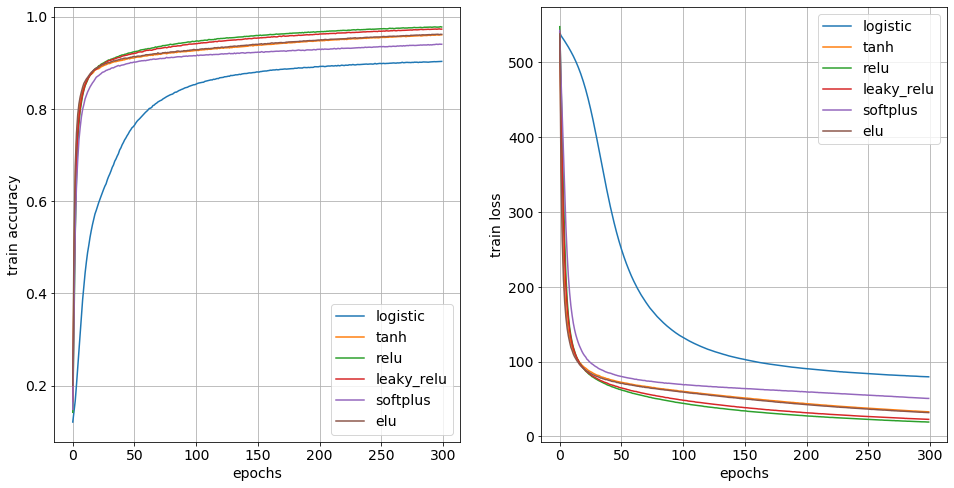

In [42]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})

plt.subplot(121)
plt.plot(range(len(logistic_performance[0])), logistic_performance[0], label='logistic')
plt.plot(range(len(tanh_performance[0])), tanh_performance[0], label='tanh')
plt.plot(range(len(relu_performance[0])), relu_performance[0], label='relu')
plt.plot(range(len(lrelu_performance[0])), lrelu_performance[0], label='leaky_relu')
plt.plot(range(len(softplus_performance[0])), softplus_performance[0], label='softplus')
plt.plot(range(len(elu_performance[0])), elu_performance[0], label='elu')
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(122)
plt.plot(range(len(logistic_performance[1])), logistic_performance[1], label='logistic')
plt.plot(range(len(tanh_performance[1])), tanh_performance[1], label='tanh')
plt.plot(range(len(relu_performance[1])), relu_performance[1], label='relu')
plt.plot(range(len(lrelu_performance[1])), lrelu_performance[1], label='leaky_relu')
plt.plot(range(len(softplus_performance[1])), softplus_performance[1], label='softplus')
plt.plot(range(len(elu_performance[1])), elu_performance[1], label='elu')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend(loc='upper right')
plt.grid()

plt.savefig('mnist_performance-256.png', dpi=300)
plt.show()